## Scene Classification using DL

#### Imports:

In [12]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from PIL import Image
import os
import cv2
import shutil
from shutil import copyfile
import random

import keras
import tensorflow as tf
from tensorflow import keras
from keras.preprocessing import image
from keras.preprocessing.image import ImageDataGenerator # from keras.preprocessing.image import ImageDataGenerator is deprecated
from sklearn.model_selection import train_test_split
from keras.utils import load_img, img_to_array
from tensorflow import keras
from keras.applications.vgg16 import VGG16
from keras.applications import ResNet50
from keras.preprocessing.image import ImageDataGenerator
from keras.layers import Dense, MaxPooling2D, BatchNormalization, Activation, Dropout, Flatten, Conv2D, GlobalAveragePooling2D
from keras.models import Model
from keras.applications.vgg16 import preprocess_input
from keras.preprocessing import image
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

#### Plot history:

In [2]:
# function to plote training history
def plot_history(history):
    # store results
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']
    loss = history.history['loss']
    val_loss = history.history['val_loss']

    # plot results
    # accuracy
    plt.figure(figsize=(5, 8))
    plt.rcParams['figure.figsize'] = [8, 4]
    plt.rcParams['font.size'] = 10
    plt.rcParams['axes.grid'] = True
    plt.rcParams['figure.facecolor'] = 'white'
    plt.subplot(2, 1, 1)
    plt.plot(acc, label='Training Accuracy')
    plt.plot(val_acc, label='Validation Accuracy')
    plt.legend(loc='lower right')
    plt.ylabel('Accuracy')
    plt.title(f'\nTraining and Validation Accuracy. \nTrain Accuracy: {str(round(acc[-1],3))}\nValidation Accuracy: {str(round(val_acc[-1],3))}')
    
    # loss
    plt.subplot(2, 1, 2)
    plt.plot(loss, label='Training Loss')
    plt.plot(val_loss, label='Validation Loss')
    plt.legend(loc='upper right')
    plt.ylabel('Cross Entropy')
    plt.title(f'Training and Validation Loss. \nTrain Loss: {str(round(loss[-1],3))}\nValidation Loss: {str(round(val_loss[-1],3))}')
    plt.xlabel('epoch')
    plt.tight_layout(pad=3.0)
    plt.show()

#### Setting up the data:

In [3]:
data = pd.read_csv('../Dataset/archive/train-scene classification/train.csv')
data.head()

,image_name,label
0,0.jpg,0
1,1.jpg,4
2,2.jpg,5
3,4.jpg,0
4,7.jpg,4


In [4]:
data["label"] = data["label"].astype(str)

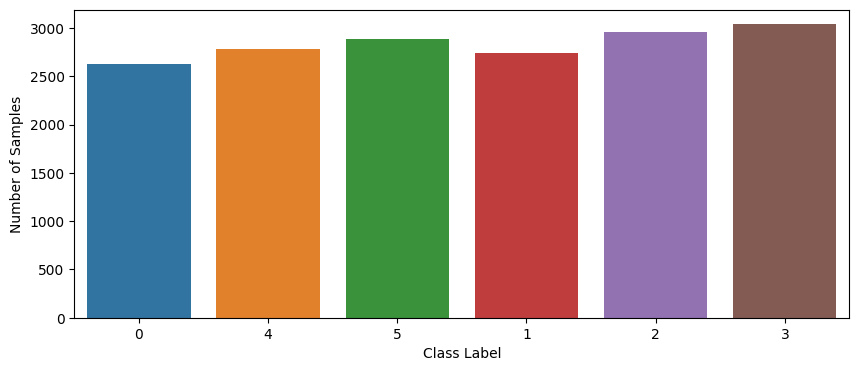

In [5]:
fig, ax = plt.subplots(figsize = (10, 4))                            
sns.countplot(x ='label', data=data)                                  
plt.xlabel("Class Label")                                                
plt.ylabel("Number of Samples")                                          
plt.show() 

In [6]:
data_train, data_test = train_test_split(data, test_size=0.2)      

In [7]:
datagen = ImageDataGenerator(rescale=1./255)   

In [8]:
dir = "../Dataset/archive/train-scene classification/train/"

In [9]:
train_gen=datagen.flow_from_dataframe(dataframe = data_train,           
                                      directory=dir,                  
                                      batch_size=20,                    
                                      class_mode="categorical",        
                                      x_col="image_name",               
                                      color_mode="rgb",            
                                      y_col="label",                    
                                      target_size=(224,224)) 

Found 13627 validated image filenames belonging to 6 classes.


In [10]:
valid_gen=datagen.flow_from_dataframe(dataframe = data_test,         
                                      directory=dir,                   
                                      batch_size=20,                    
                                      class_mode="categorical",         
                                      x_col="image_name",              
                                      color_mode="rgb",                
                                      y_col="label",                    
                                      target_size=(224,224))            

Found 3407 validated image filenames belonging to 6 classes.


#### Approach 1: ResNet15V2

In [11]:
ResNet_model = keras.applications.ResNet152V2(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

234545216/234545216 [==============================] - 76s 0us/step


In [13]:
for layer in ResNet_model.layers[:-15]:       # Freezing all layers other than last 15 Layers
    layer.trainable = False

x = ResNet_model.output
x = GlobalAveragePooling2D()(x)
x = Flatten()(x)
x = Dense(units=512, activation='relu')(x)
x = Dropout(0.3)(x)
x = Dense(units=512, activation='relu')(x)
x = Dropout(0.3)(x)
output  = Dense(units=6, activation='softmax')(x)
model = Model(ResNet_model.input, output)

In [14]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 224, 224, 3)]        0         []                            
                                                                                                  
 conv1_pad (ZeroPadding2D)   (None, 230, 230, 3)          0         ['input_1[0][0]']             
                                                                                                  
 conv1_conv (Conv2D)         (None, 112, 112, 64)         9472      ['conv1_pad[0][0]']           
                                                                                                  
 pool1_pad (ZeroPadding2D)   (None, 114, 114, 64)         0         ['conv1_conv[0][0]']          
                                                                                              

In [16]:
loss = keras.losses.CategoricalCrossentropy()
optimizer = keras.optimizers.legacy.Adam(learning_rate=0.001)
model.compile(optimizer=optimizer, loss=loss, metrics= ['accuracy'])

In [17]:
STEP_SIZE_TRAIN=train_gen.n//train_gen.batch_size
STEP_SIZE_VALID=valid_gen.n//valid_gen.batch_size

In [18]:
STEP_SIZE_TRAIN

681

In [19]:
STEP_SIZE_VALID

170

In [20]:
history = model.fit_generator(generator=train_gen,
                            steps_per_epoch=STEP_SIZE_TRAIN,
                            validation_data=valid_gen,
                            validation_steps=STEP_SIZE_VALID,
                            epochs=5)

Epoch 1/5


/var/folders/zv/x2lv03fs46n15fxz2b08zwx00000gn/T/ipykernel_2279/4094779763.py:1: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  history = model.fit_generator(generator=train_gen,
2023-07-23 16:44:43.805807: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] PluggableGraphOptimizer failed: INVALID_ARGUMENT: Unparseable tensorflow.GraphDef proto
2023-07-23 16:44:43.924799: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] PluggableGraphOptimizer failed: INVALID_ARGUMENT: Unparseable tensorflow.GraphDef proto


681/681 [==============================] - ETA: 0s - loss: 0.3939 - accuracy: 0.8739

2023-07-23 16:49:01.072858: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] PluggableGraphOptimizer failed: INVALID_ARGUMENT: Unparseable tensorflow.GraphDef proto
2023-07-23 16:49:01.189472: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] PluggableGraphOptimizer failed: INVALID_ARGUMENT: Unparseable tensorflow.GraphDef proto


681/681 [==============================] - 332s 478ms/step - loss: 0.3939 - accuracy: 0.8739 - val_loss: 0.2892 - val_accuracy: 0.9018
Epoch 2/5
681/681 [==============================] - 408s 600ms/step - loss: 0.2423 - accuracy: 0.9206 - val_loss: 0.2374 - val_accuracy: 0.9241
Epoch 3/5
681/681 [==============================] - 429s 631ms/step - loss: 0.1891 - accuracy: 0.9355 - val_loss: 0.4409 - val_accuracy: 0.8950
Epoch 4/5
681/681 [==============================] - 429s 629ms/step - loss: 0.1486 - accuracy: 0.9478 - val_loss: 0.2812 - val_accuracy: 0.9129
Epoch 5/5
681/681 [==============================] - 427s 627ms/step - loss: 0.1267 - accuracy: 0.9569 - val_loss: 0.2899 - val_accuracy: 0.9118


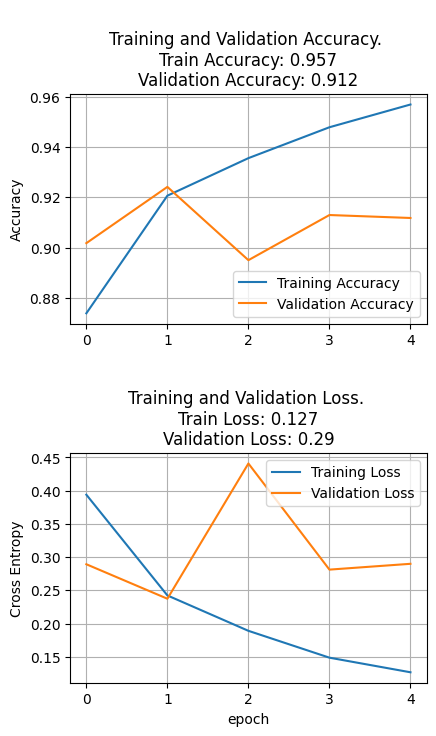

In [21]:
plot_history(history)

#### Approach 2: CNN

In [29]:
# Model Definition
INPUT_SHAPE = (224, 224, 3)

model = keras.Sequential()

model.add(Conv2D(32, (3, 3), input_shape = INPUT_SHAPE))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Conv2D(32, (3, 3), kernel_initializer = 'he_uniform'))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Conv2D(32, (3, 3), kernel_initializer = 'he_uniform'))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Flatten())

model.add(Dense(64))
model.add(Activation('relu'))
model.add(Dropout(0.5))

model.add(Dense(1))
model.add(Activation('sigmoid'))


In [30]:
model.compile(loss='binary_crossentropy',
             optimizer='Adam',
             metrics=['accuracy'])

In [31]:
model.summary()

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_7 (Conv2D)           (None, 222, 222, 32)      896       
                                                                 
 activation_8 (Activation)   (None, 222, 222, 32)      0         
                                                                 
 max_pooling2d_6 (MaxPoolin  (None, 111, 111, 32)      0         
 g2D)                                                            
                                                                 
 conv2d_8 (Conv2D)           (None, 109, 109, 32)      9248      
                                                                 
 activation_9 (Activation)   (None, 109, 109, 32)      0         
                                                                 
 max_pooling2d_7 (MaxPoolin  (None, 54, 54, 32)        0         
 g2D)                                                 

In [32]:
history = model.fit_generator(generator=train_gen,
                            steps_per_epoch=STEP_SIZE_TRAIN,
                            validation_data=valid_gen,
                            validation_steps=STEP_SIZE_VALID,
                            epochs=5)

Epoch 1/5


/var/folders/zv/x2lv03fs46n15fxz2b08zwx00000gn/T/ipykernel_2279/4094779763.py:1: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  history = model.fit_generator(generator=train_gen,
2023-07-23 17:29:47.381185: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] PluggableGraphOptimizer failed: INVALID_ARGUMENT: Unparseable tensorflow.GraphDef proto
2023-07-23 17:29:47.393285: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] PluggableGraphOptimizer failed: INVALID_ARGUMENT: Unparseable tensorflow.GraphDef proto


681/681 [==============================] - ETA: 0s - loss: 0.4613 - accuracy: 0.8323

2023-07-23 17:30:22.537189: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] PluggableGraphOptimizer failed: INVALID_ARGUMENT: Unparseable tensorflow.GraphDef proto
2023-07-23 17:30:22.541775: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] PluggableGraphOptimizer failed: INVALID_ARGUMENT: Unparseable tensorflow.GraphDef proto


681/681 [==============================] - 39s 56ms/step - loss: 0.4613 - accuracy: 0.8323 - val_loss: 0.4532 - val_accuracy: 0.8333
Epoch 2/5
681/681 [==============================] - 38s 56ms/step - loss: 0.4553 - accuracy: 0.8333 - val_loss: 0.4522 - val_accuracy: 0.8333
Epoch 3/5
681/681 [==============================] - 38s 56ms/step - loss: 0.4534 - accuracy: 0.8333 - val_loss: 0.4513 - val_accuracy: 0.8333
Epoch 4/5
681/681 [==============================] - 41s 60ms/step - loss: 0.4519 - accuracy: 0.8333 - val_loss: 0.4508 - val_accuracy: 0.8333
Epoch 5/5
681/681 [==============================] - 48s 71ms/step - loss: 0.4511 - accuracy: 0.8333 - val_loss: 0.4507 - val_accuracy: 0.8333


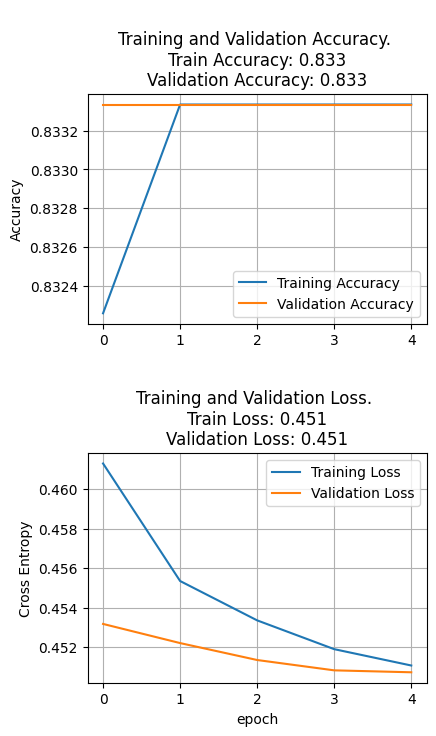

In [34]:
plot_history(history)

In [35]:
_, acc = model.evaluate(valid_gen, verbose=0)
print("Accuracy: ", (acc*100.0), " %")

Accuracy:  83.33338499069214  %


#### Approach 3: VGG16

In [36]:
# Load the pre-trained VGG19 model
base_model = VGG16(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
base_model.trainable = False

In [37]:
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Flatten()(x)
x = Dense(units=512, activation='relu')(x)
x = Dropout(0.3)(x)
x = Dense(units=512, activation='relu')(x)
x = Dropout(0.3)(x)
output  = Dense(units=6, activation='softmax')(x)
model = Model(base_model.input, output)

In [38]:
model.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0   

In [39]:
model.compile(optimizer = tf.keras.optimizers.legacy.Adam(),
            loss = 'binary_crossentropy',
            metrics=['accuracy'])

In [40]:
history = model.fit_generator(generator=train_gen,
                            steps_per_epoch=STEP_SIZE_TRAIN,
                            validation_data=valid_gen,
                            validation_steps=STEP_SIZE_VALID,
                            epochs=5)

Epoch 1/5


/var/folders/zv/x2lv03fs46n15fxz2b08zwx00000gn/T/ipykernel_2279/4094779763.py:1: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  history = model.fit_generator(generator=train_gen,
2023-07-23 17:35:15.598704: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] PluggableGraphOptimizer failed: INVALID_ARGUMENT: Unparseable tensorflow.GraphDef proto
2023-07-23 17:35:15.612521: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] PluggableGraphOptimizer failed: INVALID_ARGUMENT: Unparseable tensorflow.GraphDef proto


681/681 [==============================] - ETA: 0s - loss: 0.1686 - accuracy: 0.7874

2023-07-23 17:39:30.715147: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] PluggableGraphOptimizer failed: INVALID_ARGUMENT: Unparseable tensorflow.GraphDef proto
2023-07-23 17:39:30.723256: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] PluggableGraphOptimizer failed: INVALID_ARGUMENT: Unparseable tensorflow.GraphDef proto


681/681 [==============================] - 329s 482ms/step - loss: 0.1686 - accuracy: 0.7874 - val_loss: 0.1151 - val_accuracy: 0.8600
Epoch 2/5
681/681 [==============================] - 355s 521ms/step - loss: 0.1163 - accuracy: 0.8599 - val_loss: 0.1114 - val_accuracy: 0.8650
Epoch 3/5
681/681 [==============================] - 350s 514ms/step - loss: 0.1064 - accuracy: 0.8727 - val_loss: 0.1034 - val_accuracy: 0.8750
Epoch 4/5
681/681 [==============================] - 355s 522ms/step - loss: 0.1020 - accuracy: 0.8794 - val_loss: 0.1014 - val_accuracy: 0.8818
Epoch 5/5
681/681 [==============================] - 359s 527ms/step - loss: 0.0978 - accuracy: 0.8845 - val_loss: 0.0967 - val_accuracy: 0.8885


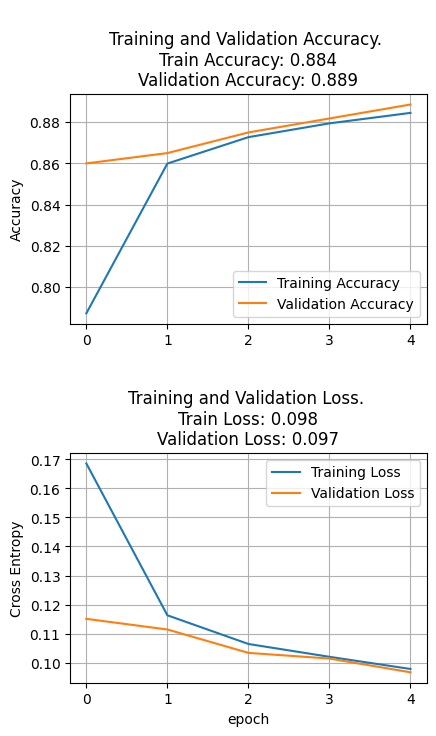

In [41]:
plot_history(history)